In [ ]:
'''modified delay injection method:
1) By sperating traffic packages, apply different delays to different detinations from the same worker node
2) gnerate more practical delay matrix;
'''

In [1]:
import paramiko

def apply_latency_between_nodes(source_node_name, username, key_path, interface, begin_latency, node_details):
    """Apply latency between source and destination nodes using SSH with a private key."""
    client = paramiko.SSHClient()
    client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    client.load_system_host_keys()
    
    try:
        source_node_ip = node_details[source_node_name]['ip']
        client.connect(source_node_ip, username=username, key_filename=key_path)
        
        # Clear existing rules:
        client.exec_command(f"sudo tc qdisc del dev {interface} root")
        client.exec_command(f"sudo tc qdisc add dev {interface} root handle 1: htb default 1") # default class 1:1, reserved for other traffics not to these nodes; otherwise, these traffic will be dropped
        client.exec_command(f"sudo tc class add dev {interface} parent 1: classid 1:1 htb rate 100mbps")
        
        mark_count = 2 #  Start from 2 to reserve 1:1 as the default class
        dst_node_details = exclude_src_node(source_node_name, node_details)
        
        for dst_node, details in dst_node_details.items():
            dst_node_ip = details['ip']
            latency = begin_latency + mark_count * 10  # Incremental latency
            print(dst_node_ip)
            
            # Form commands with proper string formatting 
            # ("rate" is the guaranteed bandwidth for the class. "ceil" is the maximum bandwidth the class can use when there is spare bandwidth available from other classes.)
            command_class_add = f"sudo tc class add dev {interface} parent 1: classid 1:{mark_count} htb rate 100mbps"
            command_delay_add = f"sudo tc qdisc add dev {interface} parent 1:{mark_count} handle {mark_count}0: netem delay {latency}ms"
            command_filter_add = f"sudo tc filter add dev {interface} protocol ip parent 1:0 prio 1 u32 match ip dst {dst_node_ip} flowid 1:{mark_count}"
            
            client.exec_command(command_class_add)
            client.exec_command(command_delay_add)
            client.exec_command(command_filter_add)
            
            print(f'From {source_node_name} to {dst_node}: injected latency {latency} ms ')
            mark_count += 1

    except Exception as e:
        print(f"Failed to apply latency for {source_node_name}: {e}")
    finally:
        client.close()

def exclude_src_node(src_node_name, node_details):
    return {name: details for name, details in node_details.items() if name != src_node_name}

def automate_latency_injection(source_node_name, begin_latency, node_details):
    username = node_details[source_node_name]['username']
    key_path = node_details[source_node_name]['key_path']
    interface = 'eth0'  # Assuming the interface name is eth0
    apply_latency_between_nodes(source_node_name, username, key_path, interface, begin_latency, node_details)

# Assuming correct IP addresses and no duplication in node keys
node_details = {
    'k8s-worker-1': {'ip': '172.26.128.30', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-2': {'ip': '172.26.132.91', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-3': {'ip': '172.26.133.31', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-4': {'ip': '172.26.132.241', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-5': {'ip': '172.26.132.142', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-6': {'ip': '172.26.133.55', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-7': {'ip': '172.26.130.22', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-8': {'ip': '172.26.130.82', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-9': {'ip': '172.26.133.118', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'}
}

automate_latency_injection('k8s-worker-1', 7, node_details)

172.26.132.91
From k8s-worker-1 to k8s-worker-2: injected latency 27 ms 
172.26.133.31
From k8s-worker-1 to k8s-worker-3: injected latency 37 ms 
172.26.132.241
From k8s-worker-1 to k8s-worker-4: injected latency 47 ms 
172.26.132.142
From k8s-worker-1 to k8s-worker-5: injected latency 57 ms 
172.26.133.55
From k8s-worker-1 to k8s-worker-6: injected latency 67 ms 
172.26.130.22
From k8s-worker-1 to k8s-worker-7: injected latency 77 ms 
172.26.130.82
From k8s-worker-1 to k8s-worker-8: injected latency 87 ms 
172.26.133.118
From k8s-worker-1 to k8s-worker-9: injected latency 97 ms 


In [2]:
dst_node_details = exclude_src_node("k8s-worker-1", node_details)
        
for dst_node, details in dst_node_details.items():
    dst_node_ip = details['ip']
    # latency = begin_latency + mark_count * 10  # Incremental latency
    print(dst_node_ip)

172.26.132.91
172.26.133.31
172.26.132.241
172.26.132.142
172.26.133.55
172.26.130.22
172.26.130.82
172.26.133.118


In [8]:
import random

# Constants
NUM_NODES = 9
BASE_LATENCY = 5  # Minimum latency in milliseconds
MAX_ADDITIONAL_LATENCY = 100  # Additional latency due to distance, congestion, etc.

# Initialize a 9x9 matrix with zeros
delay_matrix = [[0 for _ in range(NUM_NODES)] for _ in range(NUM_NODES)]

# Generate delays
for i in range(NUM_NODES):
    for j in range(NUM_NODES):
        if i == j:
            # Same node communication, assume a small base latency
            delay_matrix[i][j] = BASE_LATENCY
        else:
            # Different nodes, add random additional latency
            additional_latency = random.uniform(0, MAX_ADDITIONAL_LATENCY)
            # Simulate higher latency for nodes further apart
            distance_factor = abs(i - j) / NUM_NODES
            simulated_latency = BASE_LATENCY + additional_latency * distance_factor
            # Simulate random network congestion
            congestion_factor = random.uniform(0.8, 1.2)
            delay_matrix[i][j] = int(simulated_latency * congestion_factor)

# Print the matrix
for row in delay_matrix:
    print(row)



[5, 5, 4, 13, 22, 33, 43, 33, 78]
[12, 5, 5, 27, 33, 36, 35, 56, 56]
[30, 11, 5, 13, 11, 15, 11, 42, 62]
[21, 23, 15, 5, 7, 27, 40, 28, 38]
[32, 23, 21, 8, 5, 17, 12, 4, 10]
[9, 9, 19, 7, 16, 5, 15, 5, 7]
[52, 19, 38, 10, 20, 4, 5, 9, 15]
[21, 25, 54, 19, 22, 17, 5, 5, 12]
[18, 46, 50, 28, 24, 30, 18, 7, 5]


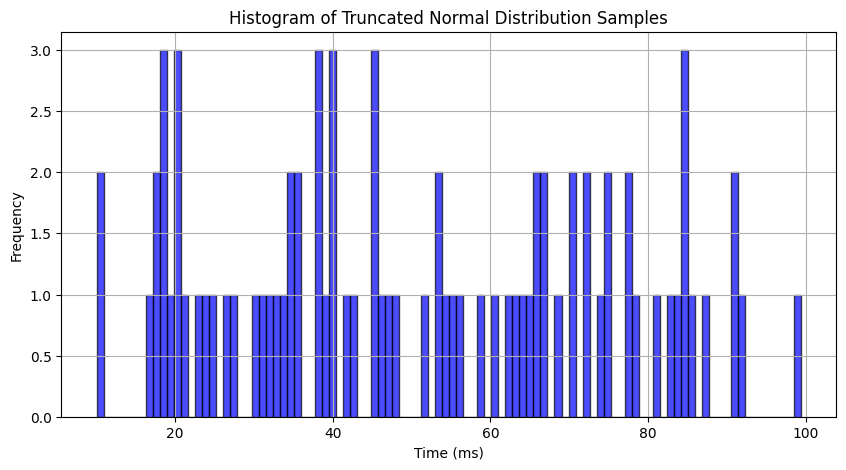

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

# Define the range and desired standard deviation
min_val, max_val = 10, 100
std_dev = 50

# Calculate the mean as the midpoint of the range for a symmetric distribution
mean_val = (max_val + min_val) / 2

# Scale the min and max to the z-scores
a, b = (min_val - mean_val) / std_dev, (max_val - mean_val) / std_dev

# Generate the truncated normal distribution
samples = truncnorm(a, b, loc=mean_val, scale=std_dev).rvs(81)

# Plotting the histogram of the generated samples
plt.figure(figsize=(10, 5))
plt.hist(samples, bins=100, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Truncated Normal Distribution Samples')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
